# 13. 로지스틱 회귀

In [2]:
library(bayesrules)
library(rstanarm)
library(bayesplot)
library(tidyverse)
library(tidybayes)
library(broom.mixed)

<br>

#### 이진 범주형변수에 대하여 사용되는 분류모형

<br>

## 13.01. 오즈 & 확률

> 특정 사건의 발생확률이 $\pi \in [0,1]$일 때, 오즈는
> $$\begin{equation}
\text{odds} = \frac{\pi}{1-\pi}  \in [0, \infty)\\.
\end{equation}$$이며
> $$\begin{equation}
\pi = \frac{\text{odds}}{1 + \text{odds}}  .
\end{equation}$$

> 오즈가 1보다 작을 때 : 사건의 발생확률이, 발생하지 않을 확률보다 작음
>
> 오즈가 1일 때 : 사건의 발생확률이, 발생하지 않을 확률과 동일 (50:50의 발생확률)
>
> 오즈가 1보다 클 때 : 사건의 발생확률이, 발생하지 않을 확률보다 높음

<br>

## 13.02. 로지스틱 회귀모형 구축
- 이산형 확률분포 $Y_i$가, 0과 1만을 가질 수 있는 베르누이 분포를 따르고,

    베르누이 분포는 확률 매개변수 $\pi$ (=사건 발생확률)을 가진다면

    $$Y_i | \pi_i \sim \text{Bern}(\pi_i)$$
    
    $$E(Y_i|\pi_i) = \pi_i.$$
    
- 로지스틱 회귀모형은 $\pi_i$에 대한 연결함수 형태가 선형임을 가정하며

    연결함수는 로짓함수

$$\log(\frac{\pi_i}{1-\pi_i}) = \beta_0 + \beta_1 X_{i1}  .$$

<br>

#### 따라서
$$\begin{equation}
Y_i|\beta_0,\beta_1 \stackrel{ind}{\sim} \text{Bern}(\pi_i) \;\; \text{ with } \;\; \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{i1}  .
\end{equation}$$

$$\begin{equation}
\frac{\pi_i}{1-\pi_i} = e^{\beta_0 + \beta_1 X_{i1}}
\;\;\;\; \text{ and } \;\;\;\;
\pi_i = \frac{e^{\beta_0 + \beta_1 X_{i1}}}{1 + e^{\beta_0 + \beta_1 X_{i1}}} .
\end{equation}$$

<br>

> $\beta_0$ 
>> $(X_1,X_2,\ldots,X_p)$가 0일 때의 로그오즈이며, $e^{\beta_0}$는 오즈

> $\beta_1$
>> $(X_2,\ldots,X_p)$가 통제된 상태에서, $X_1 = x$일 때의 오즈가 $odds_{x}$이고 $X_1 = x + 1$일 때의 오즈가 $\text{odds}_{x+1}$라면
>> 
>> $\beta_1$는 $X$가 1단위 증가하면서 발생하는 로그오즈 변동량이며, $e^{\beta_1}$은 오즈 변동량
>>
>> $$\beta_1 = \log(\text{odds}_{x+1}) - \log(\text{odds}_x)
\;\;\; \text{ and } \;\;\; e^{\beta_1} = \frac{\text{odds}_{x+1}}{\text{odds}_x}.$$

<br>

### 사전분포 설정

In [3]:
data(weather_perth)

weather <- weather_perth %>% 
  select(day_of_year, raintomorrow, humidity9am, humidity3pm, raintoday)

### MCMC 시뮬레이션으로 autoscale된 사전분포

In [ ]:
rain_model_prior <- stan_glm(raintomorrow ~ humidity9am,
                             data = weather, family = binomial,
                             prior_intercept = normal(-1.4, 0.7),
                             prior = normal(0.07, 0.035),
                             chains = 4, iter = 5000*2, seed = 84735,
                             prior_PD = TRUE)

In [5]:
prior_summary(rain_model_prior)

Priors for model 'rain_model_prior' 
------
Intercept (after predictors centered)
 ~ normal(location = -1.4, scale = 0.7)

Coefficients
 ~ normal(location = 0.07, scale = 0.035)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.01in} & Y_i|\beta_0,\beta_1 & \stackrel{ind}{\sim} \text{Bern}(\pi_i) \;\; \text{ with } \;\; \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{i1} \\
\text{priors:} & & \beta_{0c}  &  \sim N\left(-1.4, 0.7^2 \right)  \\
               & & \beta_1  & \sim N\left(0.07, 0.035^2 \right). \\
\end{array}
\end{equation}$$

<br>

## 13.03. 사후분포 시뮬레이션

In [ ]:
rain_model_1 <- update(rain_model_prior, prior_PD = FALSE)

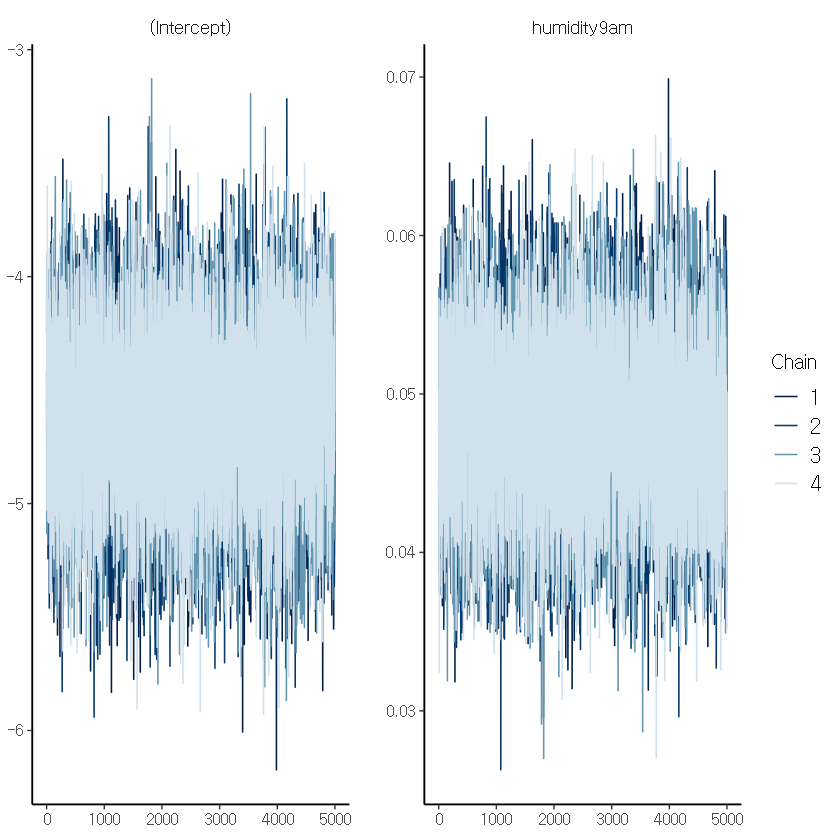

Warning message:
"The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the bayesplot package.
  Please report the issue at <https://github.com/stan-dev/bayesplot/issues/>."


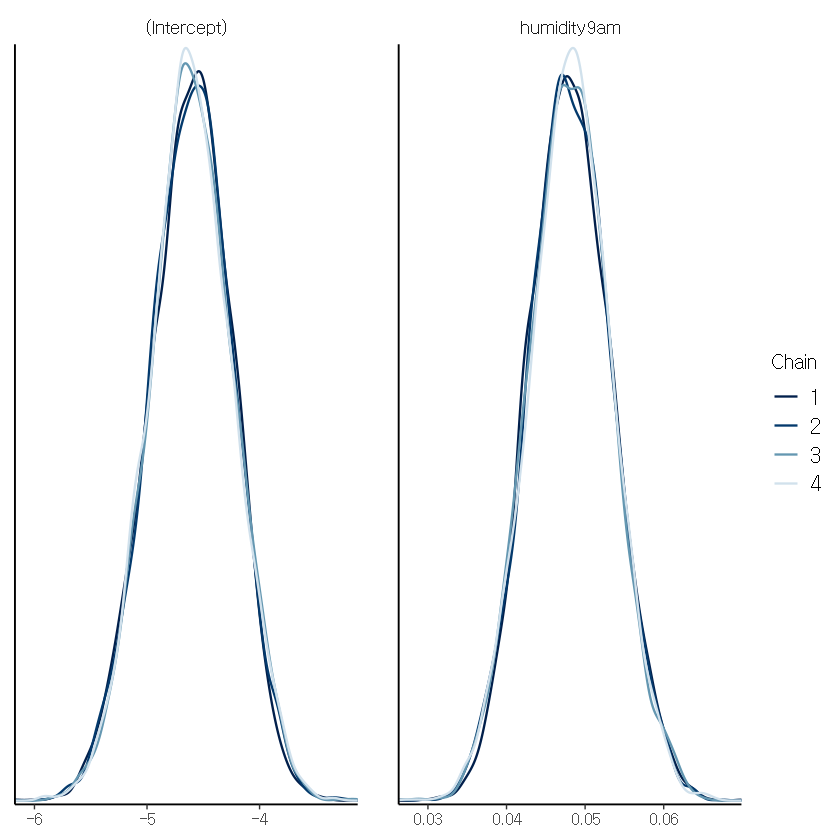

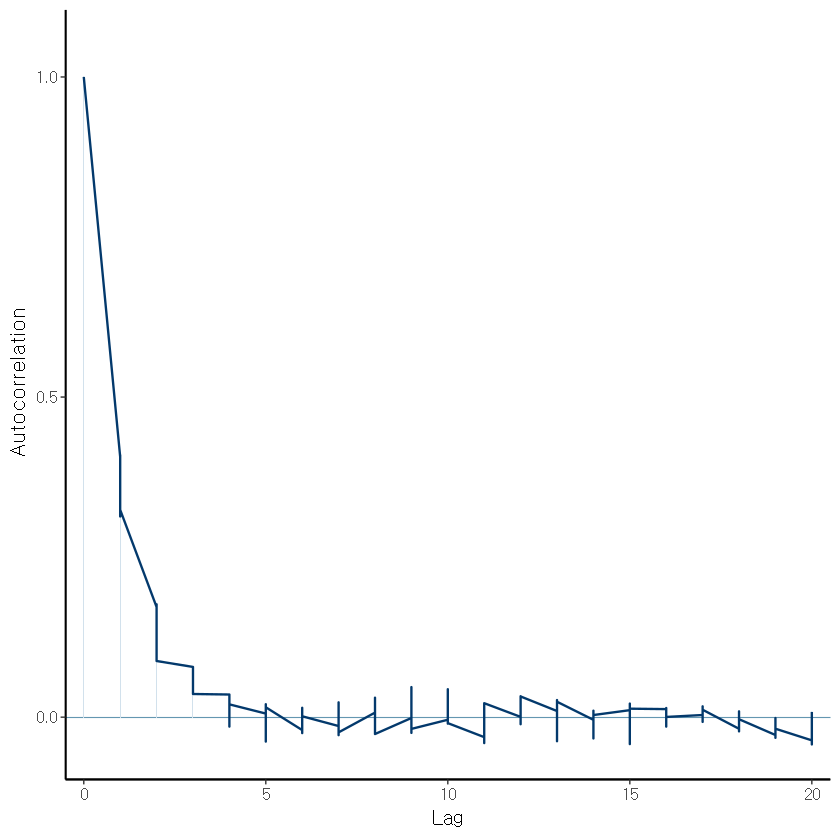

In [9]:
mcmc_trace(rain_model_1)
mcmc_dens_overlay(rain_model_1)
mcmc_acf(rain_model_1)

Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."


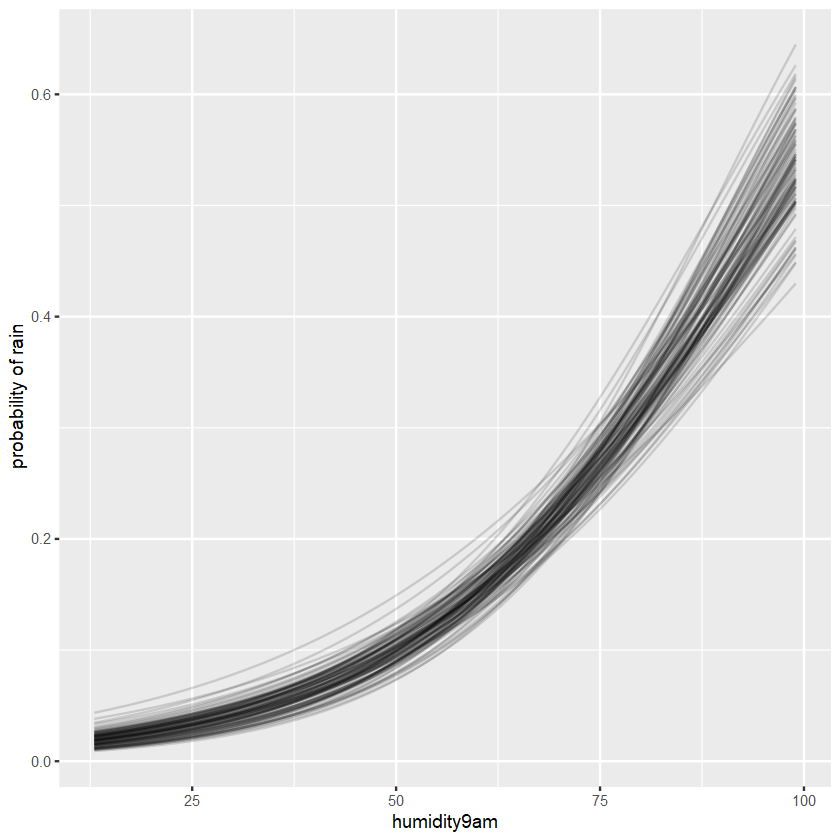

In [10]:
weather %>%
  add_fitted_draws(rain_model_1, n = 100) %>%
  ggplot(aes(x = humidity9am, y = raintomorrow)) +
    geom_line(aes(y = .value, group = .draw), alpha = 0.15) + 
    labs(y = "probability of rain")

<br>

### 매개변수별 사후분포 신용구간

In [11]:
posterior_interval(rain_model_1, prob = 0.80)

,10%,90%
(Intercept),-5.08784667,-4.13449813
humidity9am,0.04146719,0.05487265


In [12]:
exp(posterior_interval(rain_model_1, prob = 0.80))

,10%,90%
(Intercept),0.006171294,0.0160107
humidity9am,1.042338958,1.0564061


<br>

## 13.04. 예측 & 분류

<br>

### 분류규칙
> $Y$가 이진 범주형 변수이고, 
>
> $\left(Y_{new}^{(1)}, Y_{new}^{(2)}, \ldots, Y_{new}^{(N)}\right)$가 길이 $N$의 마르코프 체인 값이며, 
>
> $p$가 관측값을 1로 분류한 비율일 때 ($Y_{new}^{(i)} = 1$)
>
> 임계값 (분석가 결정) $c \in [0,1]$을 기준으로
>
> $p \ge c$라면 1로 분류하고, $p < c$라면 0으로 분류

<br>


### $humidity9am=99$인 관측값에 대한 분류

In [24]:
set.seed(84735)
binary_prediction <- posterior_predict(
  rain_model_1, newdata = data.frame(humidity9am = 99))

# set.seed(84735)
# rain_model_1_df <- as.data.frame(rain_model_1) %>% 
#   mutate(log_odds = `(Intercept)` + humidity9am*99,
#          odds = exp(log_odds),
#          prob = odds / (1 + odds),
#          Y = rbinom(20000, size = 1, prob = prob))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


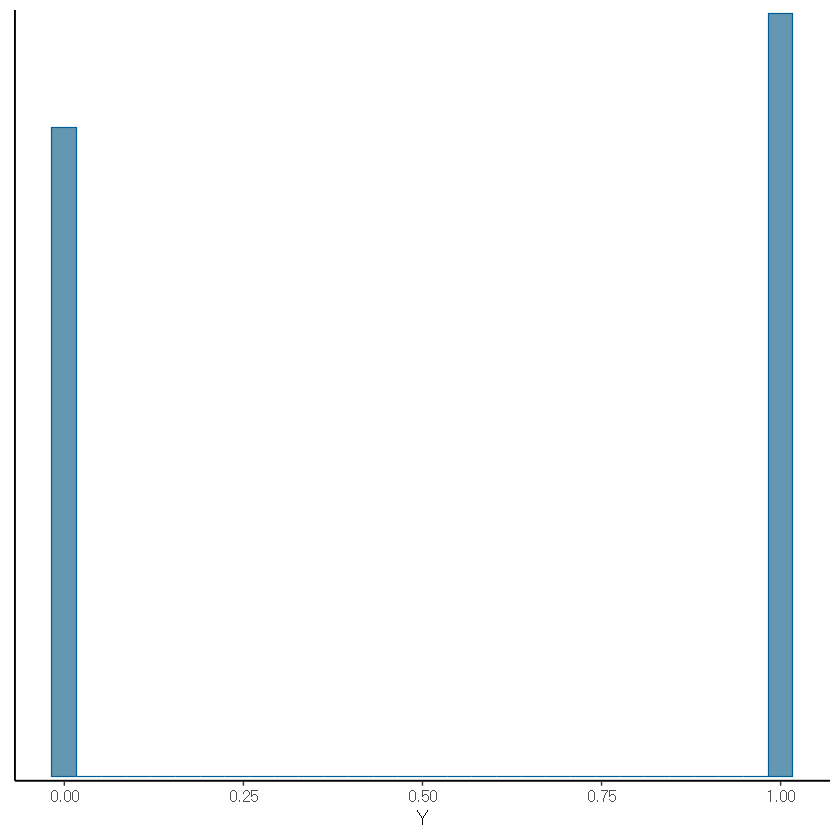

In [25]:
mcmc_hist(binary_prediction) + 
  labs(x = "Y")

# ggplot(rain_model_1_df, aes(x = Y)) + 
#   stat_count()

<br>

###  $humidity9am=99$인 관측값을 1로 분류할 확률은 54.02% $\rightarrow$ 1로 분류 (예측)

In [26]:
table(binary_prediction)

binary_prediction
    0     1 
 9196 10804 

In [27]:
colMeans(binary_prediction)

1 
0.5402

<br>

## 13.05. 모형 평가

### 기존 관측값에 대한 분류예측

In [32]:
set.seed(84735)
rain_pred_1 <- posterior_predict(rain_model_1, newdata = weather)
dim(rain_pred_1)

[1] 20000  1000

In [34]:
rain_pred_1 %>% head(1)

1,2,3,4,5,6,7,8,9,10,⋯,991,992,993,994,995,996,997,998,999,1000
0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


<br>

In [36]:
weather_classifications <- weather %>% 
  mutate(rain_prob = colMeans(rain_pred_1),
         rain_class_1 = as.numeric(rain_prob >= 0.5)) %>% 
  select(humidity9am, rain_prob, rain_class_1, raintomorrow)

In [39]:
weather_classifications %>% head()

humidity9am,rain_prob,rain_class_1,raintomorrow
<int>,<dbl>,<dbl>,<fct>
55,0.12180,0,No
43,0.07390,0,No
62,0.16335,0,Yes
53,0.11580,0,No
65,0.18615,0,No
84,0.36205,0,No


<br>

### 분류예측 정확도 평가
- $Y$가 관측값 (실제값), $\hat{Y}$가 예측값일 때, 아래와 같은 혼동행렬에 대해서

    (a + b + c + d = n)
    
    <br>
    
    - **분류예측 정확도는**
    
        $$\text{overall accuracy} = \frac{a + d}{a + b + c + d}.$$
        
    <br>
    
    - **민감도(TPR)** : 실제값 1이, 1로 제대로 분류예측된 비율
    
    - **정밀도(TNR)** : 실제값 0이, 0으로 제대로 분류예측된 비율
    
        $$\text{sensitivity} = \frac{d}{c + d}
\;\;\;\; \text{ and } \;\;\;\;
\text{specificity} = \frac{a}{a + b}.$$

        - (민감도와 정밀도는 Trade-Off 관계)

<table>
<thead>
<tr class="header">
<th></th>
<th align="center"><span class="math inline">\(\hat{Y} = 0\)</span></th>
<th align="center"><span class="math inline">\(\hat{Y} = 1\)</span></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td><span class="math inline">\(Y = 0\)</span></td>
<td align="center"><span class="math inline">\(a\)</span></td>
<td align="center"><span class="math inline">\(b\)</span></td>
</tr>
<tr class="even">
<td><span class="math inline">\(Y = 1\)</span></td>
<td align="center"><span class="math inline">\(c\)</span></td>
<td align="center"><span class="math inline">\(d\)</span></td>
</tr>
</tbody>
</table>

<br>

#### `bayesrules::classification_summary(model, data, cutoff)` : 임곗값을 `cutoff`로 설정하였을 때 `data`에 대한 분류 정확도

In [41]:
set.seed(84735)
classification_summary(model = rain_model_1, data = weather, cutoff = 0.5)

$confusion_matrix
   y   0  1
  No 803 11
 Yes 172 14

$accuracy_rates
                           
sensitivity      0.07526882
specificity      0.98648649
overall_accuracy 0.81700000

<br>

### 교차검증 정확도

#### `bayesrules::classification_summary_cv(model, data, cutoff, k)`

In [43]:
set.seed(84735)
cv_accuracy_1 <- classification_summary_cv(
  model = rain_model_1, data = weather, cutoff = 0.5, k = 10)
cv_accuracy_1$cv

sensitivity,specificity,overall_accuracy
<dbl>,<dbl>,<dbl>
0.08399622,0.9836725,0.815


<br>

## 13.06. 모형의 비교

### 설명변수를 추가된 모형

In [ ]:
rain_model_2 <- stan_glm(
  raintomorrow ~ humidity9am + humidity3pm + raintoday, 
  data = weather, family = binomial,
  prior_intercept = normal(-1.4, 0.7),
  prior = normal(0, 2.5, autoscale = TRUE), 
  chains = 4, iter = 5000*2, seed = 84735)

In [45]:
prior_summary(rain_model_2)

Priors for model 'rain_model_2' 
------
Intercept (after predictors centered)
 ~ normal(location = -1.4, scale = 0.7)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0], scale = [2.5,2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0,0], scale = [0.14,0.15,6.45])
------
See help('prior_summary.stanreg') for more details

$$\begin{split}
Y_i | \beta_0, \beta_1, \beta_2, \beta_3 & \sim Bern(\pi_i) \;\; \text{ with } \;\; \log\left(\frac{\pi_i}{1-\pi_i}\right) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} +  \beta_3  X_{i3} \\
\beta_{0c} & \sim N(-1.4, 0.7^2) \\
\beta_1 & \sim N(0, 0.14^2) \\
\beta_2 & \sim N(0, 0.15^2) \\
\beta_3 & \sim N(0, 6.45^2). \\
\end{split}$$

In [46]:
tidy(rain_model_2, effects = "fixed", conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-5.459830116,0.482668939,-6.07703382,-4.850371399
humidity9am,-0.006932239,0.007369322,-0.01631853,0.002505842
humidity3pm,0.079589920,0.008458789,0.06887451,0.090615307
raintodayYes,1.154229133,0.220201090,0.87430149,1.435999167


<br>

### 2개 모형의 정확도 비교

In [ ]:
set.seed(84735)
cv_accuracy_2 <- classification_summary_cv(
  model = rain_model_2, data = weather, cutoff = 0.2, k = 10)

In [48]:
cv_accuracy_1$cv

sensitivity,specificity,overall_accuracy
<dbl>,<dbl>,<dbl>
0.08399622,0.9836725,0.815


In [49]:
cv_accuracy_2$cv

sensitivity,specificity,overall_accuracy
<dbl>,<dbl>,<dbl>
0.7521557,0.8139202,0.802


<br>

### 2개 모형의 ELPD 비교
- 첫 번째 모형의 ELPD 추정량이, 두 번째 모형의 ELPD 추정량에 2 표준오차보다 ($-80.2 \pm 2*13.5$) 높음 

    $\rightarrow$ 예측의 측면에서, 두 번째 모형이 더 좋음

In [50]:
loo_1 <- loo(rain_model_1)
loo_2 <- loo(rain_model_2)

In [51]:
loo_compare(loo_1, loo_2)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
rain_model_2,0.00000,0.00000,-356.8451,20.79331,4.159501,0.3383917,713.6902,41.58662
rain_model_1,-80.18955,13.51344,-437.0346,18.97491,2.169906,0.1728632,874.0693,37.94982
